In [65]:

from river.base.classifier import Classifier as RiverClassifer
import queue
import pandas as pd
import typing
import inspect
import operator

In [66]:
import river
import river.datasets as datasets
from river import stream
from pprint import pprint
import os
from scipy.io import arff
import pandas as pd
from river import tree
from river import evaluate
from river import metrics

import numpy as np
from  streams.stream_section import StreamSection
from streams.utils import FL, FU, generate_stream_section
from my_datasets.getting_datasets import get_LED,get_Hyperplane,get_Electricity,get_AGRAWL,get_Airlines,get_CoverType,get_RandomRBF
from train_and_eval import train_and_evaluate
from functools import partial
from train_and_eval import train_and_evaluate
from river.metrics.accuracy import Accuracy
from multiprocessing.pool import ThreadPool
from river.datasets.synth import ConceptDriftStream
from tqdm import tqdm

# methods
from river.dummy import NoChangeClassifier,PriorClassifier
from river.cluster import CluStream
from river.forest.adaptive_random_forest import ARFClassifier
from river.tree.hoeffding_adaptive_tree_classifier import  HoeffdingAdaptiveTreeClassifier
from river.neighbors import KNNClassifier as riverKNN
from river.naive_bayes import GaussianNB
from semisupervised_methods.clustream_and_label import CluserAndLabel
from semisupervised_methods.incremental_classifier import IncrementalClassifer
from semisupervised_methods.one_nearest_neighbour import oneNNClassifer
from river.drift import ADWIN, PageHinkley


In [67]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [68]:
from streams.utils import FL, FU, generate_stream_section
from streams.stream_section import StreamSection
from river import metrics
from multiprocessing.pool import ThreadPool
from constants import NUMBER_OF_THREADS, FREQUENCY_OF_PREDICTIONS
import numpy as np
import logging
import datetime
from river.utils import Rolling

def get_most_frequent(predictions):
    ''' 
    Get the most common predction

    Parameters
    ----------
    predictions: list
        The list of predicted labels

    Returns
    ---------
    int
        The most popular class

    '''
    return max(set(predictions), key=predictions.count)


def update_performance_measures(predictions, true_label, B, metrics):
    ''' 
    The prediction for each awaiting (for a label) instance is made every K iterations 

    Parameters
    ----------
    predictions: dict
        The dictionary of predctions 

    true_label: int
        The true class of an instance

    B: int
        Number of bins #TODO add somewhere the describtion

    metrics: dict
        The dictionary holding the metrics to calculate the results
    '''
    interval = (len(predictions)-1)/B
    preds = list(predictions.values())
    for b in range(B+2):
        if b == 0:
            metrics[b].update(true_label, preds[0])
        if b == B+1:
            metrics[b].update(true_label, preds[-1])
        if preds[int(1+interval*(b)):int((1+interval*(b+1)))]: #interval not empty
                y_pred = get_most_frequent(
                    preds[int(1+interval*(b)):int((1+interval*(b+1)))])
                metrics[b].update(true_label, y_pred)


def make_prediction_for_awaiting(h, cur_idx, P, L, K):
    ''' 
    The prediction for each awaiting (for a label) instance is made every K iterations 

    Parameters
    ----------
    h: classifier
        The trained classifer that predicts the class

    cur_idx: int
        The index of a currently processed observation

    P: dict
        The dictionary with predictions 

    L: dict
        The dictionary with awaiting results

    K: int
        The number indicates how often the predction is made

    '''
    # foreach instance in L add predictionin time cur_idx in P
    for idx, instance in L.items():
        # make prediction every K instances
        if abs(idx-cur_idx) % K == 0:
            P[idx][cur_idx] = h.predict_one(instance)


def add_delay_constant(stream, delay, no_delete_period, dataset_name, q):
    new_stream = []
    i = 0
    for idx_1, idx_2, x, y, in stream:
        if i < no_delete_period:
            new_stream.append((i, i, x, y))
            i = i+1
            continue
        if (i-no_delete_period) % delay == 0 and i-no_delete_period != 0:
            i += delay
        new_stream.append((i, i, x, None))
        new_stream.append((i+delay, i, x, y))
        i += 1
    new_stream.sort(key=lambda x: x[0])
    return StreamSection(f'{dataset_name}_delay_{q[0]}_{q[1]}', new_stream, False)

def add_delay_random(stream, max_delay, no_delete_period, dataset_name, q):
    """ Add random delay (1, max_delay)"""
    new_stream = []
    used_indexes = []
    i = 0
    for idx_1, idx_2, x, y, in stream:
        if i < no_delete_period:
            new_stream.append((i, i, x, y))
            i = i+1
            continue
        while i in used_indexes:
            i+=1
        delay = np.random.randint(1,max_delay)
        while i+delay in used_indexes:
            delay+=1 # if sampling again infinite loop possible
        new_stream.append((i, i, x, None))
        new_stream.append((i+delay, i, x, y))
        used_indexes.extend([i,i+delay])
        i += 1
    new_stream.sort(key=lambda x: x[0])
    return StreamSection(f'{dataset_name}_delay_{q[0]}_{q[1]}', new_stream, False)


def generate_streams(initial_stream, dataset_name, q, probas, delay_type, delay, warm_up_period):
    stream_set = []  # TODO chcek where this should be placed

    stream_set.append(initial_stream)
    if delay_type == 1:
        initial_stream = add_delay_constant(
            initial_stream.stream, delay, warm_up_period, dataset_name, q)
        dataset_name += '_constant_delay'
        stream_set.append(initial_stream)
    elif delay_type == 2:
        initial_stream = add_delay_random(
            initial_stream.stream, delay, warm_up_period, dataset_name, q)
        dataset_name += '_random_delay'
        stream_set.append(initial_stream)

    for p in probas:
        ssl_stream = StreamSection(f'{dataset_name}_ssl_{p}_{q[0]}_{q[1]}', FU(
            initial_stream.stream, p, warm_up_period), False)
        lfs_stream = StreamSection(
            f'{dataset_name}_lfs_{p}_{q[0]}_{q[1]}', FL(ssl_stream.stream), True)
        stream_set.append(ssl_stream)
        stream_set.append(lfs_stream)
    return stream_set



def train_for_stream( my_stream,methods, methods_params,methods_name,
                       metric_fun, K, B,warm_up_period, max_length):
    results = {}
    predictions = {}
    # how many labelled instances appered -> needed for prediction of awaiting examples 
    labelled_insances_cnt = 0
    logging.debug(f" Start processing {my_stream.__name__}")
    for mi, method in enumerate(methods):
            # initilaze method and variables
        m = method(**methods_params[mi])
        metrics = [metric_fun() for _ in range(B+2)]
        periodc_metric = Rolling(metric_fun(),window_size = FREQUENCY_OF_PREDICTIONS )
        final_pred_history = []
        h = m
        L = {}
        P = {}
        preds = []
        logging.debug(f" Start processing method {methods_name[mi]}")
        for cur_idx, init_idx, x, y in my_stream.stream:
            # TODO: can it be in this place
           
            # unlabelled instance
            if y is None:
                # add instnace and index
                L[cur_idx] = x
                P[cur_idx] = {}
                # predict if after warm up period
                if m._timestamp > warm_up_period:
                    P[cur_idx][cur_idx] = h.predict_one(x)
                    # TODO: think what to do if the method cannot deal with unlabelled
                    preds.append(max(h.predict_proba_one(
                    x).items(), key=operator.itemgetter(1))[1])
                    h = h.learn_one(x)

            # labelled instance
            else:
                labelled_insances_cnt+=1
                periodc_metric.update(y, h.predict_one(x))
                if cur_idx != init_idx and init_idx in P.keys():  # delayed label
                    P[init_idx][cur_idx] = h.predict_one(x)
                    L.pop(init_idx)

                    update_performance_measures(
                        P[init_idx], y, B, metrics)
                # TODO: probably need to implment a better option of evaluation-> for now test then train is used
                else: #TODO: dopytac sie czy tojest ok 
                    if m._timestamp > warm_up_period:  # if in warmup period the prediction cannot be made
                        # if it was not delayed only last prediction exists
                        metrics[B+1].update(y, h.predict_one(x))
                        
                
                make_prediction_for_awaiting(h, labelled_insances_cnt, P, L, K) 
                h = h.learn_one(x, y)
                if labelled_insances_cnt %FREQUENCY_OF_PREDICTIONS == 0 and labelled_insances_cnt>0 :
                    final_pred_history.append(periodc_metric.get())
        method_params = ' '.join([f"({k};{v})" for k,v in m._get_params().items()])
        predictions_through_time = [str(final_pred_history[t])  if t< len(final_pred_history) else "" for t in range(max_length)]
    

        predictions_through_time = ', '.join(predictions_through_time)
        logging.info(f"{my_stream.__name__}, {method_params}, {B},{FREQUENCY_OF_PREDICTIONS}, {', '.join([str(t.get())for t in metrics])},{predictions_through_time}")        
        results[methods_name[mi]] = metrics,final_pred_history,preds
        
    return my_stream.__name__,results

# K how many new labelled instances need to arrive before the new prediction is made
def train_and_evaluate(initial_stream, dataset_name, Q, probas, methods, methods_params,methods_name,
                       metric_fun, delay_type, K, B, delay,warm_up_period=10):
    '''
    The initial stream section needs to passed
    Main evaluation and traing function
    delay_type - 0 - NONE, 1 - equal, 2- random
    '''

    now = datetime.datetime.now()
    date_time = now.strftime("%d_%m_%Y_%H_%M_%S")
    logging.basicConfig(filename=f'logs\\{date_time}.log', filemode='w', format='%(asctime)s - %(message)s',level=logging.INFO,datefmt='%d-%b-%y %H:%M:%S')
    pool = ThreadPool(NUMBER_OF_THREADS)
    results = {}
    for q in Q:
        # preparing streams part
        stream_set = generate_streams(
            initial_stream, dataset_name, q, probas, delay_type, delay,warm_up_period,)
        logging.debug('Streams generated')
        # train and evaluation part
        max_length = int(np.ceil(max([len(st.stream) for st in stream_set])/FREQUENCY_OF_PREDICTIONS))
        results_for_q = []
 
        for my_stream in stream_set[1:]:
            results_for_q.append(train_for_stream( my_stream,methods, methods_params, methods_name,
                       metric_fun, K, B,warm_up_period,max_length))
            
    
            
        results[q] = results_for_q
    return results

        


In [69]:
class MyClassifier(RiverClassifer):
    def __init__(self,classifer,clustering_method, classifier_params,clustering_params,time_window):
        """
        
        Parameters
        ----------

        classifer: RiverClassifer (probably)
            base classifer, needs to have a predict_proba (TODO: chceck what if not)
        
        clustering_method: Sklearn style cliustering method
            clustering method for unlabelled instances
        
        classifier_params: dict
            parameters for the classifier

        clustering_params: dict
            parameters for the clustering method

        time_window: int
            after how many labelled instances the prediction on centers are made #TODO decide if I should count labelled or unlabelled instances
        """
        super().__init__()
        self.counter = 0 # counter of the labelled instances
        self.classifier= classifer(**classifier_params)
        self.clustering_method = clustering_method(**clustering_params)
        self.time_window = time_window
        self._timestamp = 0
        self.unlabelled_instances = [] # I considered queue but since we need the whole chunk of data list of dicts
        # seems to be more resonable

    def _learn_from_unlabelled(self,columns):

        # train the clustering method


        X = pd.DataFrame.from_records(self.unlabelled_instances)
        self.unlabelled_instances.clear()
        if len(X) <4: # TODO: number of clusters
            return
        self.clustering_method = self.clustering_method.fit(X)

        #TODO: rewrite vectorize
        predicted_labels = []
        for i,center in enumerate(self.clustering_method.cluster_centers_):
            x = dict(zip(columns,center))
            y_proba = self.classifier.predict_proba_one(x)
            y = self.classifier.predict_one(x)
            # print(i,y_proba)
            predicted_labels.append((x,y))

        for x,y in predicted_labels:
            self._timestamp+=1
            self.classifier = self.classifier.learn_one(x,y)

    def learn_one(self,x,y=None):
        if y is None:
            self.unlabelled_instances.append(x)
            return self
        else:
            self._timestamp+=1
            self.classifier = self.classifier.learn_one(x=x, y=y)
            if self._timestamp%self.time_window == 0:
                self._learn_from_unlabelled(list(x.keys()))
            return self

    def predict_one(self, x):
        return self.classifier.predict_one(x=x)

    def predict_proba_one(self, x):
        return self.classifier.predict_proba_one(x=x)


    def _get_params(self) -> typing.Dict[str, typing.Any]:
        """Return the parameters that were used during initialization."""

        params = {}

        for name, param in inspect.signature(self.classifier.__init__).parameters.items():  # type: ignore
        
            # Keywords parameters
            attr = getattr(self.classifier, name)
            params[f"classifier_"+ str(name)] = attr

        for name, param in inspect.signature(self.clustering_method.__init__).parameters.items():  # type: ignore
        
            # Keywords parameters
            attr = getattr(self.clustering_method, name)
            params[f"clustering_"+ str(name)] = attr


        params['clustering'] = self.clustering_method.__class__
        params['classifier'] = self.classifier.__class__
        params['time_window'] = self.time_window
            

        return params





In [70]:
rbf = get_RandomRBF(change_speed=0.0001,n_centroids=50)
initial_stream_r = generate_stream_section(rbf,'initail_RBF_moderate','initail_RBF_moderate',start=0,stop=20000)

In [71]:
led3 = get_LED(0.1,True,3)
led5 = get_LED(0.1,True,5)
led7 = get_LED(0.1,True,7)

cds = ConceptDriftStream(ConceptDriftStream(led3,led5,position=3750,width = 3750),ConceptDriftStream(led5,led7,position=7500,width = 5000), position=7500,width=7500)
initial_stream_l = generate_stream_section(cds,'initail_LED_Drift_gradual','initail_LED_Drift_gradual',start=0,stop=20000)

In [72]:
dataset_name = 'LED_gradual'
Q=[(0,20000)]
probas = [0.1,0.2,0.5]
ARF1 = ARFClassifier
ARF2 = ARFClassifier
ARF3 = ARFClassifier
NB1 = GaussianNB
NB3 = GaussianNB
NB2 = GaussianNB
incClasif1 = IncrementalClassifer
incClasif2= IncrementalClassifer
incClasif3 = IncrementalClassifer
incClasif4 = IncrementalClassifer
incClasif5= IncrementalClassifer
incClasif6 = IncrementalClassifer
m_params = [
 {'threshold':0.9,
  'classifier':ARF1,
  'params':{'seed':123}},
  {'threshold':0.8,
  'classifier':ARF2,
  'params':{'seed':123}},
  {'threshold':0.7,
  'classifier':ARF3,
  'params':{'seed':123}},
  {'threshold':0.9,
  'classifier':NB1,
  'params':{}},
  {'threshold':0.8,
  'classifier':NB2,
  'params':{}},
  {'threshold':0.7,
  'classifier':NB3,
  'params':{}}]
methods = [incClasif1,incClasif2,incClasif3,incClasif4,incClasif5,incClasif6]
resl= train_and_evaluate(initial_stream_l,dataset_name,Q,probas,methods,m_params,['ARF','ARF','ARF','NB','NB','NB'],Accuracy,1,B=50,K=10,delay=1000)

In [73]:
dataset_name = 'RBF_moderate'
Q=[(0,20000)]
probas = [0.1,0.2,0.5]
ARF1 = ARFClassifier
ARF2 = ARFClassifier
ARF3 = ARFClassifier
NB1 = GaussianNB
NB3 = GaussianNB
NB2 = GaussianNB
incClasif1 = IncrementalClassifer
incClasif2= IncrementalClassifer
incClasif3 = IncrementalClassifer
incClasif4 = IncrementalClassifer
incClasif5= IncrementalClassifer
incClasif6 = IncrementalClassifer
m_params = [
 {'threshold':0.9,
  'classifier':ARF1,
  'params':{'seed':123}},
  {'threshold':0.8,
  'classifier':ARF2,
  'params':{'seed':123}},
  {'threshold':0.7,
  'classifier':ARF3,
  'params':{'seed':123}},
  {'threshold':0.9,
  'classifier':NB1,
  'params':{}},
  {'threshold':0.8,
  'classifier':NB2,
  'params':{}},
  {'threshold':0.7,
  'classifier':NB3,
  'params':{}}]
methods = [incClasif1,incClasif2,incClasif3,incClasif4,incClasif5,incClasif6]
resr = train_and_evaluate(initial_stream_r,dataset_name,Q,probas,methods,m_params,['ARF','ARF','ARF','NB','NB','NB'],Accuracy,1,B=50,K=10,delay=1000)

In [ ]:
res[(0,20000)][0]

('RBF_moderate_delay_0_20000',
 {'ARF': ([Accuracy: 61.31%,
    Accuracy: 0.00%,
    Accuracy: 0.00%,
    Accuracy: 0.00%,
    Accuracy: 64.44%,
    Accuracy: 61.50%,
    Accuracy: 67.00%,
    Accuracy: 65.50%,
    Accuracy: 58.00%,
    Accuracy: 62.50%,
    Accuracy: 0.00%,
    Accuracy: 62.00%,
    Accuracy: 63.75%,
    Accuracy: 71.60%,
    Accuracy: 62.81%,
    Accuracy: 0.00%,
    Accuracy: 59.83%,
    Accuracy: 0.00%,
    Accuracy: 68.51%,
    Accuracy: 59.30%,
    Accuracy: 0.00%,
    Accuracy: 65.50%,
    Accuracy: 65.19%,
    Accuracy: 0.00%,
    Accuracy: 60.32%,
    Accuracy: 0.00%,
    Accuracy: 0.00%,
    Accuracy: 65.47%,
    Accuracy: 64.50%,
    Accuracy: 59.55%,
    Accuracy: 0.00%,
    Accuracy: 68.51%,
    Accuracy: 0.00%,
    Accuracy: 60.17%,
    Accuracy: 61.11%,
    Accuracy: 64.50%,
    Accuracy: 70.99%,
    Accuracy: 63.25%,
    Accuracy: 62.50%,
    Accuracy: 59.55%,
    Accuracy: 71.60%,
    Accuracy: 59.00%,
    Accuracy: 65.00%,
    Accuracy: 68.00%,
    Ac

In [ ]:
list(res[(0,20000)][2][1].values())[0][2]

[]

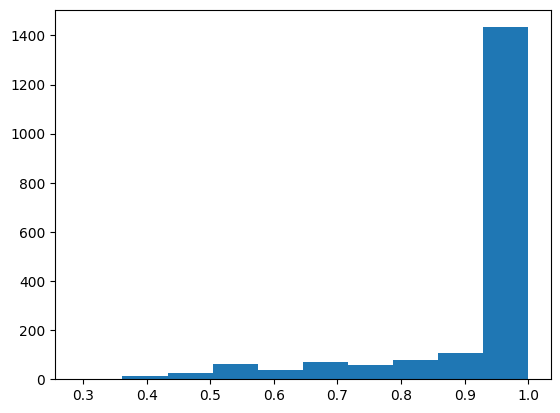

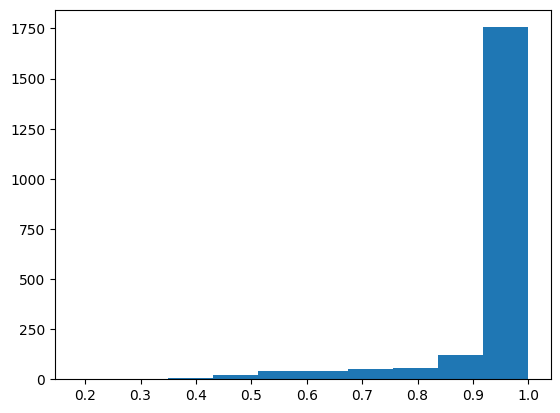

In [ ]:
for i in [0,1]:
    plt.hist(list(res[(0,20000)][i][1].values())[0][2], bins=10)
    plt.show()

In [ ]:
dataset_name = 'RBF_moderate'
Q=[(0,20000)]
probas = [0.1,0.2,0.5]
my_method = MyClassifier
my_method1 = MyClassifier
my_method2= MyClassifier
HT = HoeffdingAdaptiveTreeClassifier
NB = GaussianNB
ARF = ARFClassifier
Cl= KMeans
m_params = [
 {  'classifer':HT,
  'clustering_method':Cl,
  'clustering_params':{'n_init':'auto','n_clusters':4},
  'classifier_params':{},
  'time_window':20},
  {  'classifer':NB,
  'clustering_method':Cl,
  'clustering_params':{'n_init':'auto','n_clusters':4},
  'classifier_params':{},
  'time_window':20},
  {  'classifer':ARF,
  'clustering_method':Cl,
  'clustering_params':{'n_init':'auto','n_clusters':4},
  'classifier_params':{},
  'time_window':20}]
methods = [my_method,my_method1,my_method2]
res = train_and_evaluate(initial_stream,dataset_name,Q,probas,methods,m_params,['MM_HT','MM_NB',"MM_ARF"],Accuracy,1,B=50,K=10,delay=1000)

In [ ]:
res

{(0,
  10000): [('initail_RBF_moderate',
   {'MM': ([Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accuracy: 0.00%,
      Accu